![Portada](https://i.pinimg.com/originals/aa/fc/95/aafc95cf0bc95a02cc263ca63c388c72.jpg)

With the aid of Bagehot's contributions (The Only Game in Town Links to an external site.), and Copeland & Galai's model (Information Effects on the Bid-Ask Spread Links to an external site.) demonstrated how, even without transaction costs, a spread would exist. This led us to maximize the market maker's profit function in terms of a Bid & Ask price.

### Parameters

1. **Stock Price Follows a Lognormal Distribution:**
   - Distribution: $
   P \sim \text{Lognormal}(60, 2.25)
   $
   - Parameters: $\mu = 60$, $\sigma^2 = 2.25$
   - Description: Indicates that the stock price follows a lognormal distribution with a mean of $60$ and a variance of $2.25$.

2. **Probability of an Informed Trade:**
   - $\Pi_I = 0.4$
   - Description: Represents the probability that a trade is informed, set at $40\%$.

3. **Buy Limit Probability ($\Pi_{LB}$) as a Function of $S$:**
   - $\Pi_{LB}(S) = 0.5 - 0.08S$
   - Constraints: $\Pi_{LB} \in [0, 0.5]$
   - Description: Defines $\Pi_{LB}$, the probability of a buy limit, as a linear function of $S$, where $S = (A - S_0)$, $A$ is the proposed stock price, and $S_0$ is the initial stock price.

4. **Sell Limit Probability ($\Pi_{LS}$) as a Function of $S$:**
   - $\Pi_{LS}(S) = 0.5 - 0.08S$
   - Constraints: $\Pi_{LS} \in [0, 0.5]$
   - Description: Defines $\Pi_{LS}$, the probability of a sell limit, as a linear function of $S$, where $S = (S_0 - B)$, $S_0$ is the initial stock price, and $B$ is the bid price.

5. **Initial Stock Price $S_0$:**
   - $S_0 = 65$
   - Description: Sets the initial stock price at $65$, indicating the price before any trades occur.


Use this wisely:

$$
\begin{aligned}
& \max _{K_A, K_B}\left\{\left(1-p_I\right)\left[p_{B L}\left(K_A-S_0\right)+p_{S L}\left(S_0-K_B\right)\right]\right.
\left.-p_I\left[\int_{K_A}^{\infty}\left(S-K_A\right) f(S) d S+\int_0^{K_B}\left(K_B-S\right) f(S) d S\right]\right\} \geq 0
\end{aligned}
$$

where: 
- $( K_A )$: Proposed selling price or "ask" price.
- $( K_B )$: Proposed buying price or "bid" price.
- $( p_I )$: Probability of an informed trade (( $Pi_I = 0.4 $)).
- $( p_{LB} )$: Buy limit probability as a function of $( S )$ ($( \Pi_{LB}(S) $)).
- $( p_{LS} )$: Sell limit probability as a function of $( S $) ($( \Pi_{LS}(S) $)).
- $( S_0 )$: Initial stock price (65).
- $( S )$: Stock price, which follows a lognormal distribution with $( \mu = 60 )$ and $( \sigma^2 = 2.25 )$.
- $( f(S) )$: The probability density function of the lognormal distribution of stock prices.


---

A Jupyter notebook containing:
- Plot the price distribution.

Create a plot showing:
- Expected revenue if all trades are liquidity trades, and $\Pi_{LB} = \Pi_{LS} = 0.5$.
- Expected revenue if there is a 40% chance that an informed trade will be executed, keep the same liquidity probabilities as the previous point.
- Expected revenue considering:
  - $\Pi_I = 0.4$
  - $\Pi_{LB}(S) = 0.5 - 0.08S$ where $\Pi_{LB}: [0, 0.5]$
  - $\Pi_{LS}(S) = 0.5 - 0.08S$ where $\Pi_{LS}: [0, 0.5]$

Determine the optimal Bid / Ask price using Copeland & Galai's model with the defined parameters.


---

In [8]:
from sympy import integrate, init_printing as sp
from sympy.abc import x as xsp
import scipy.stats as st
import scipy.optimize as opt
import tqdm
from scipy.integrate import quad
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.optimize import minimize
from scipy.stats import lognorm
from scipy.integrate import quad

### Distribution's price plot

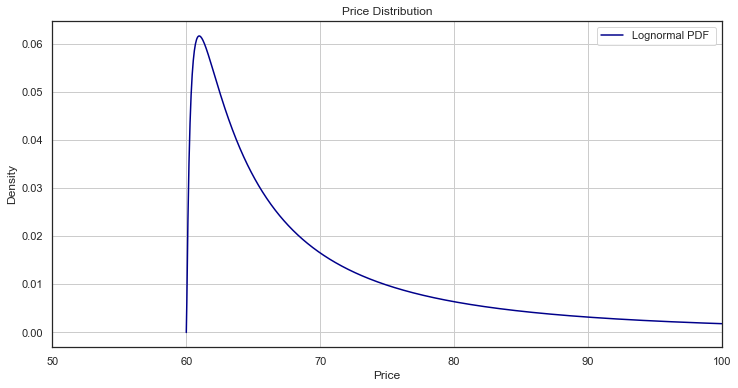

In [9]:
mu = 60
sigma = np.sqrt(2.25)
P = np.random.lognormal(np.log(mu), sigma, size=100)  # Tam
x = np.linspace(60.0001,100,1000)
y = lambda x: (1 / x * sigma *(2*np.pi)**(1/2)) * np.exp(-((np.log(x-mu))**2/(2*sigma**2)))
plt.figure(figsize=(12,6))
plt.plot(x, y(x), 
         color = 'darkblue', 
         label = 'Lognormal PDF ')
plt.title('Price Distribution'), plt.xlabel('Price'), plt.ylabel('Density')
plt.xlim(50,100)
plt.grid(), plt.legend();

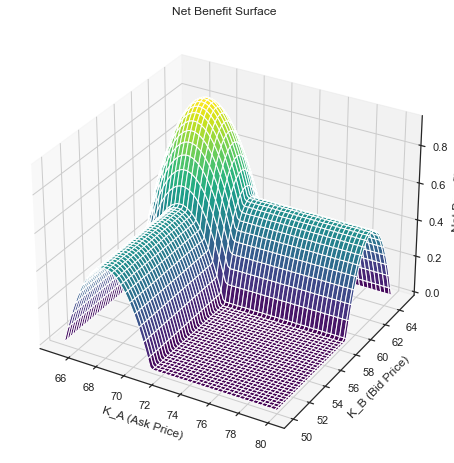

In [10]:
mu = 60
sigma = np.sqrt(2.25)
scale = np.exp(mu)

pi_I = 0.4
S_0 = 65

def lognorm_pdf(x):
    return lognorm.pdf(x, s=sigma, scale=scale)

# Funciones para el beneficio de liquidez, ajustadas para el rango [0, 0.5]
def pi_LB(K_A):
    return max(0, min(0.5, 0.5 - 0.08 * (K_A - S_0)))

def pi_LS(K_B):
    return max(0, min(0.5, 0.5 - 0.08 * (S_0 - K_B)))

def objective_function(K):
    K_A, K_B = K  #
    income = (1 - pi_I) * (pi_LB(K_A) * (K_A - S_0) + pi_LS(K_B) * (S_0 - K_B))

 
    integral_above_K_A, _ = quad(lambda S: (S - K_A) * lognorm_pdf(S), K_A, np.inf)
    integral_below_K_B, _ = quad(lambda S: (K_B - S) * lognorm_pdf(S), 0, K_B)
    cost = pi_I * (integral_above_K_A + integral_below_K_B)

    
    return -(income - cost)


K_A_values = np.linspace(S_0, S_0 + 10*sigma, 100)
K_B_values = np.linspace(S_0 - 10*sigma, S_0, 100)

# Calculamos el beneficio neto para cada combinación de K_A y K_B
benefit_surface = np.zeros((len(K_A_values), len(K_B_values)))

for i, K_A in enumerate(K_A_values):
    for j, K_B in enumerate(K_B_values):
        benefit_surface[i, j] = -objective_function([K_A, K_B])  

# Gráfico de la superficie del beneficio neto
KA_grid, KB_grid = np.meshgrid(K_A_values, K_B_values, indexing='ij')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(KA_grid, KB_grid, benefit_surface, cmap='viridis')

ax.set_xlabel('K_A (Ask Price)')
ax.set_ylabel('K_B (Bid Price)')
ax.set_zlabel('Net Benefit')
ax.set_title('Net Benefit Surface')
plt.show()

In [11]:
initial_guess = [S_0+ sigma, S_0 - sigma]
bounds = [(S_0, None), (S_0-10*sigma , S_0)] 
result = minimize(objective_function, initial_guess, bounds=bounds)
bid = result.x[1]  
ask = result.x[0]
print(f'Resultado de la optimización: revenue esperado de {round(-result.fun, 4)}, con un bid de ${round(bid, 2)} y un ask de ${round(ask,2)}')

Resultado de la optimización: revenue esperado de 0.9375 con un bid de $61.88 y un ask de $68.13
